<a href="https://colab.research.google.com/github/tg-bomze/Style-Transfer-Collection/blob/master/(Video)_PyTorch_Multi_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><font color="black" size="+4">PyTorch-Multi-Style-Transfer (VIDEO)</font></b>

<b><font color="black" size="+2">Based on:</font></b>

**GitHub repository**: [PyTorch-Multi-Style-Transfer](https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer)

Article: [Multi-style Generative Network for Real-time Transfer](https://arxiv.org/pdf/1703.06953.pdf)

Creators: **[Hang Zhang](https://github.com/zhanghang1989), [Kristin Dana](http://eceweb1.rutgers.edu/vision/dana.html).**

<b><font color="black" size="+2">Colab created by:</font></b>

GitHub: [@tg-bomze](https://github.com/tg-bomze),
Telegram: [@bomze](https://t.me/bomze),
Twitter: [@tg_bomze](https://twitter.com/tg_bomze).

---


```
(ENG) To get started, click on the button (where the red arrow indicates). After clicking, wait until the execution is complete.
```
```
(RUS) Чтобы начать, нажмите на кнопку (куда указывает красная стрелка), после чего дождитесь завершения выполнения блока.
```


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Install all necessary components</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Установить все необходимые компоненты</font></b>

!pip install torchfile
!pip install ffmpeg
!git clone https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer.git
%cd /content/PyTorch-Multi-Style-Transfer/experiments
!bash /content/PyTorch-Multi-Style-Transfer/experiments/models/download_model.sh

# import numpy & pytorch
import os
import io
import cv2
from PIL import Image
import imageio
import numpy as np
import torch
from google.colab import files
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import clear_output
from IPython.display import HTML
import moviepy.editor as mpy
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
from IPython import display as ipythondisplay
from IPython.display import Image as ipythonimage
%matplotlib inline

# define Gram Matrix
class GramMatrix(nn.Module):
    def forward(self, y):
        (b, ch, h, w) = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram
# proposed Inspiration(CoMatch) Layer
class Inspiration(nn.Module):
    """ Inspiration Layer (from MSG-Net paper)
    tuning the featuremap with target Gram Matrix
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, C, B=1):
        super(Inspiration, self).__init__()
        # B is equal to 1 or input mini_batch
        self.weight = nn.Parameter(torch.Tensor(1,C,C), requires_grad=True)
        # non-parameter buffer
        self.G = Variable(torch.Tensor(B,C,C), requires_grad=True)
        self.C = C
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.uniform_(0.0, 0.02)

    def setTarget(self, target):
        self.G = target

    def forward(self, X):
        # input X is a 3D feature map
        self.P = torch.bmm(self.weight.expand_as(self.G),self.G)
        return torch.bmm(self.P.transpose(1,2).expand(X.size(0), self.C, self.C), X.view(X.size(0),X.size(1),-1)).view_as(X)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'N x ' + str(self.C) + ')'
# some basic layers, with reflectance padding
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        self.reflection_padding = int(np.floor(kernel_size / 2))
        if self.reflection_padding != 0:
            self.reflection_pad = nn.ReflectionPad2d(self.reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample_layer(x)
        if self.reflection_padding != 0:
            x = self.reflection_pad(x)
        out = self.conv2d(x)
        return out

class Bottleneck(nn.Module):
    """ Pre-activation residual block
    Identity Mapping in Deep Residual Networks
    ref https://arxiv.org/abs/1603.05027
    """
    def __init__(self, inplanes, planes, stride=1, downsample=None, norm_layer=nn.BatchNorm2d):
        super(Bottleneck, self).__init__()
        self.expansion = 4
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes * self.expansion,
                                                        kernel_size=1, stride=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    ConvLayer(planes, planes, kernel_size=3, stride=stride)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)
        
    def forward(self, x):
        if self.downsample is not None:
            residual = self.residual_layer(x)
        else:
            residual = x
        return residual + self.conv_block(x)
    
class UpBottleneck(nn.Module):
    """ Up-sample residual block (from MSG-Net paper)
    Enables passing identity all the way through the generator
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, inplanes, planes, stride=2, norm_layer=nn.BatchNorm2d):
        super(UpBottleneck, self).__init__()
        self.expansion = 4
        self.residual_layer = UpsampleConvLayer(inplanes, planes * self.expansion,
                                                      kernel_size=1, stride=1, upsample=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    UpsampleConvLayer(planes, planes, kernel_size=3, stride=1, upsample=stride)]
        conv_block += [norm_layer(planes),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(planes, planes * self.expansion, kernel_size=1, stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return  self.residual_layer(x) + self.conv_block(x)
# the MSG-Net
class Net(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, n_blocks=6, gpu_ids=[]):
        super(Net, self).__init__()
        self.gpu_ids = gpu_ids
        self.gram = GramMatrix()

        block = Bottleneck
        upblock = UpBottleneck
        expansion = 4

        model1 = []
        model1 += [ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                            norm_layer(64),
                            nn.ReLU(inplace=True),
                            block(64, 32, 2, 1, norm_layer),
                            block(32*expansion, ngf, 2, 1, norm_layer)]
        self.model1 = nn.Sequential(*model1)

        model = []
        self.ins = Inspiration(ngf*expansion)
        model += [self.model1]
        model += [self.ins]    

        for i in range(n_blocks):
            model += [block(ngf*expansion, ngf, 1, None, norm_layer)]
        
        model += [upblock(ngf*expansion, 32, 2, norm_layer),
                            upblock(32*expansion, 16, 2, norm_layer),
                            norm_layer(16*expansion),
                            nn.ReLU(inplace=True),
                            ConvLayer(16*expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def setTarget(self, Xs):
        F = self.model1(Xs)
        G = self.gram(F)
        self.ins.setTarget(G)

    def forward(self, input):
        return self.model(input)

def tensor_load_rgbimage(filename, size=None, scale=None, keep_asp=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if keep_asp:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)

    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img

def tensor_save_rgbimage(tensor, filename, cuda=False):
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)


def tensor_save_bgrimage(tensor, filename, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename, cuda)
    
def preprocess_batch(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

os.system('wget -O 21styles.model https://www.dropbox.com/s/2iz8orqqubrfrpo/21styles.model?dl=1')

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload video (content)</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить видео (оригинал)</font></b>

!rm -rf video
!mkdir video
uploaded = list(files.upload().keys())

if len(uploaded) > 1:
  raise ValueError('You cannot upload more than one video at a time!')

vid = uploaded[0]
os.rename(vid, vid.replace(" ", ""))
vid = vid.replace(" ", "")
!mv -f $vid video/driving.mp4
vid = '/content/PyTorch-Multi-Style-Transfer/experiments/video/driving.mp4'

fps_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FPS))
frames_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FRAME_COUNT))

Первый кадр: 


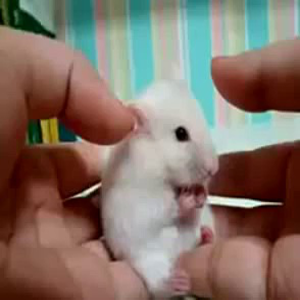

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Split video into frames</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Порезать видео на кадры</font></b>

!rm -rf frames
!mkdir frames

frames_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FRAME_COUNT))
fps_of_video = int(cv2.VideoCapture(vid).get(cv2.CAP_PROP_FPS))
vidcap = cv2.VideoCapture(vid)
success,image = vidcap.read()
count = 0
success = True
while success:
  cv2.imwrite("frames/frame%09d.jpg" % count, image)
  success,image = vidcap.read()
  count += 1

frames = []
fram = os.listdir("/content/PyTorch-Multi-Style-Transfer/experiments/frames")
fram.sort()

fram_path = '/content/PyTorch-Multi-Style-Transfer/experiments/frames/' + fram[0]
print("First frame:\n")
display(Image.open(fram_path).resize((300, 300)))

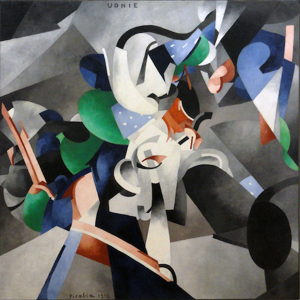

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Upload image (style)</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Загрузить фото (стиль)</font></b>

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
os.rename(fn, fn.replace(" ", ""))
fn = fn.replace(" ", "")
pic_name = "photo." + fn.split(".")[-1]
!mv -f $fn $pic_name

display(Image.open(pic_name).resize((300, 300)))

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Style Transfer</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Перенести стиль из фото на видео</font></b>
%%time
!rm -rf stylized_frames
!mkdir stylized_frames

im = Image.open(fram_path)
(width, height) = im.size
max_cont_size = max(width, height)

model_path = '/content/PyTorch-Multi-Style-Transfer/experiments/models/21styles.model'
for i in range(len(fram)):
  temp_path = '/content/PyTorch-Multi-Style-Transfer/experiments/frames/' + fram[i]
  output_path = '/content/PyTorch-Multi-Style-Transfer/experiments/stylized_frames/stylized_' + fram[i]
  !python main.py eval --content-image $temp_path --style-image $pic_name --model $model_path --content-size $max_cont_size --output-image $output_path --cuda 1
  perc = round(((len(fram)-(i+1))*100)/len(fram))
  if perc % 10 == 0:
    clear_output()
    print("Выполнено на: {}%".format(str(100 - perc)))
    print("Осталось обработать кадров: {}".format(str(len(fram)-(i+1))))
clear_output()

CPU times: user 1.27 s, sys: 498 ms, total: 1.77 s
Wall time: 5min 20s


In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Join frames in a video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Собрать кадры в видео</font></b>
!ffmpeg -y -i $vid -vn -ar 44100 -ac 2 -ab 192K -f mp3 sound.mp3
staffs = []
img = os.listdir("/content/PyTorch-Multi-Style-Transfer/experiments/stylized_frames")
img.sort()
for i in img:
  staffs.append("/content/PyTorch-Multi-Style-Transfer/experiments/stylized_frames/"+i)

staff = cv2.imread(staffs[0])  # get size from the 1st frame
writer = cv2.VideoWriter(
    'stylized_video.mp4',
    cv2.VideoWriter_fourcc(*'MP4V'),   # codec (*'DIVX', *'MP4V', *'FMP4', *'MJPG', *'XVID', *'MP4S')
    fps_of_video,  # fps
    (staff.shape[1], staff.shape[0]),  # width, height
    isColor=len(staff.shape) > 2)
for staff in map(cv2.imread, staffs):
    writer.write(staff)
writer.release()

dstvid = 'stylized_video.mp4'
tmpfile = dstvid.replace('.mp4', '-audio.mp4')
!ffmpeg -i sound.mp3 -i $dstvid $tmpfile
!rm -rf $dstvid
!mv -f $tmpfile $dstvid

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Open the final video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Открыть финальное видео</font></b>
display(mpy.ipython_display("/content/PyTorch-Multi-Style-Transfer/experiments/stylized_video.mp4", height=400, autoplay=1, loop=1, maxduration=600))

In [ ]:
#@title <b><font color="red" size="+3">←</font><font color="black" size="+3"> Download the final video</font></b>
#@markdown <b><font color="black" size="+1"> (RUS) Скачать финальное видео</font></b>
files.download('/content/PyTorch-Multi-Style-Transfer/experiments/stylized_video.mp4')